<a href="https://colab.research.google.com/github/TmnGitHub/CMR_Deep_Learning/blob/main/CMR_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----------------------------------------------------------------------------
AUTHORS: 

Taman Upadhaya <tamanupadhaya@gmail.com>

Description: semantic segmentation of CMR dataset 
-----------------------------------------------------------------------------

Many of the tasks we work on require preprocessing imedical images in formats and styles that work for deep learning. Even with annotated images, there is work in making sure the data is cleaned in a way that makes deep learning tasks feasible. 

1. Preprocessing code: For example, here is a still image of a cardiac MRI that has been annotated by humans (the right ventricle has been traced in red, left ventricle traced in green, and the entire heart in blue. We'd like to get to the output on the right:  binary masks for deep learning model training. 

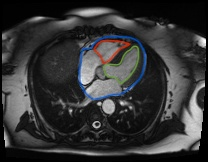
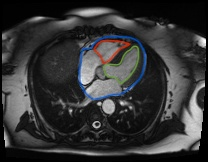PA9ADN2A_4Ch_14.jpg](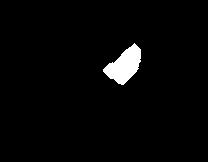)
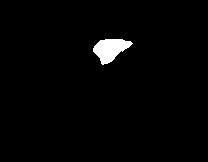
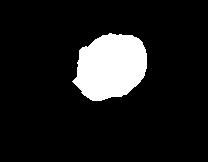

The traced and untraced images are available at https://www.dropbox.com/sh/y04enlb48wrx7mo/AAA7PqtQrH-yXNtSavncIFe-a?dl=0 

Write code to process the images into the images shown on right

In [ ]:
import cv2
import numpy as np
import os
import skimage.segmentation
import scipy
import matplotlib.pyplot as plt
from copy import deepcopy
import sys
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving UCLA_Test_2.jpeg to UCLA_Test_2.jpeg


UCLA_Test_2.jpeg


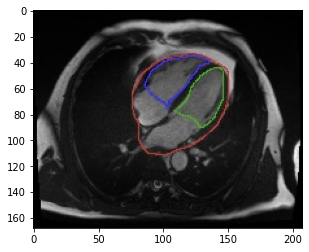

In [ ]:
for fn in uploaded.keys():
  print(fn)
  file = cv2.imread(fn)
  plt.imshow(file)

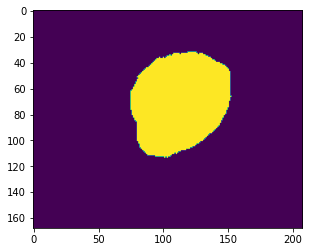

In [ ]:
def draw_mask(input_img, threshold_lower=(100,55,55), threshold_upper=(190,85,95)):
  
  mask = cv2.inRange(input_img,threshold_lower,threshold_upper)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
  dilated = cv2.dilate(mask, kernel)
  cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]

  for c in cnts:
      cv2.drawContours(mask, [c], -1, (255,255,255), -1)

  return mask

my_mask = draw_mask(file)
plt.imshow(my_mask)

Here is a potential hint if you are stuck: 
https://stackoverflow.com/questions/57669562/how-to-fill-a-polygon-using-opencv-python<BR>

In [ ]:
mask.shape

(168, 208)

# Deep Learning

# New Section

Now that you have a set of medical images and labels, write a training loop for training a segmentation model. 
1. What files did you use?

- From folder AC 12 files were randmy selected. From folder trace corresponding trace image were selected and single mask as showin in figure above were extracted for each of the the corresponding images using above mask extraction algorithm.

2. What loss did you use? 
- BCEWithLogitsLoss() loss were used for optimization and dice score was used to mesure the performance of algorithm.

3. How did you design the dataloader?
- First CMRDataset was created using the inheritance from class Dataset of pytorch. Then using the albumentations  class data in traning were agumented. Finaly with the help of Dataloader iterator batching, suffling and loading was done. 


In [ ]:
import torch
import torchvision
import torch.nn as nn
from tqdm import tqdm
import torchvision.transforms.functional as TF
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.optim as optim
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2

In [ ]:
# if error come regarding ToTensorV2 run the below pip
#!pip install albumentations==0.4.6

In [ ]:

import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Defining semantic segmeantion DL model

class Conv_des(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Conv_des,self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False), 
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False), 
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        )
  
  def forward(self, x):
    return self.conv(x)

class Seg_segmantic(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
    super(Seg_segmantic, self).__init__()
    self.up_conv = nn.ModuleList()
    self.down_conv = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    #Down convolution
    for feature in features:
      self.down_conv.append(Conv_des(in_channels, feature))
      in_channels = feature

    #Up convolution
    for feature in reversed(features):
      self.up_conv.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
      self.up_conv.append(Conv_des(feature*2,feature))

    self.bottom_layer = Conv_des(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0],out_channels, kernel_size=1)
  
  def forward(self, x):
    skip_conn = []

    for down_c in self.down_conv:
      x = down_c(x)
      skip_conn.append(x)
      x = self.pool(x)

    x = self.bottom_layer(x)
    
    skip_conn = skip_conn[::-1]

    for idx in range(0, len(self.up_conv), 2):
      x = self.up_conv[idx](x)
      skip_conn2 = skip_conn[idx//2]

      if x.shape != skip_conn2.shape:
        x = TF.resize(x, size=skip_conn2.shape[2:]) # to have the shape of up and down conv match when concatenating

      concat_skip =  torch.cat((skip_conn2, x), dim=1)
      x = self.up_conv[idx+1](concat_skip)
    
    return self.final_conv(x)


def test_model():
 x = torch.randn((3, 1, 161, 161))
 print(x.shape)
 model = Seg_segmantic(in_channels=1, out_channels=1)
 preds = model(x)
 print(preds.shape)
 assert preds.shape == x.shape

if __name__ == "__main__":
 test_model()

torch.Size([3, 1, 161, 161])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([3, 1, 161, 161])


In [ ]:
#Datset preperation

class CMRDataset(Dataset):
  def __init__(self, dir_img, dir_mask, transform=None):
    self.dir_img = dir_img
    self.dir_mask = dir_mask
    self.transform = transform
    self.images = os.listdir(dir_img)

  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, index):
    path_img = os.path.join(self.dir_img, self.images[index])
    path_mask = os.path.join(self.dir_mask, self.images[index])

    image = np.array(Image.open(path_img))

    # preprocessing to get he mask region
    mask = np.array(Image.open(path_mask), dtype=np.float32)
    mask[mask > 0.0] = 1.0
    mask[mask <= 0.0] = 0.0

    if self.transform is not None:
      augmentations = self.transform(image=image, mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]

    return image, mask


In [ ]:
def get_loaders(dir_train, dir_train_mask, dir_val, dir_val_mask, batch_size, transform_train, transform_val, num_workers=2, pin_memory=True):

  dataset_train = CMRDataset(dir_img=dir_train, dir_mask=dir_train_mask, transform=transform_train)

  train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=True)

  dataset_val = CMRDataset(dir_img=dir_val, dir_mask=dir_val_mask, transform=transform_val)

  val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

  return train_loader, val_loader

In [ ]:
def dice_score(loader, model, device="cuda"):
  
  dice=0
  model.eval()

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device)
      preds = torch.sigmoid(model(x))
      preds = (preds > 0.5).float()

      dice += (2*(preds*y).sum())/((preds+y).sum() + 1e-9)

  print(f"Dice score: {dice/len(loader)}")
  model.train()

In [ ]:
def save_pred_as_img(loader, model, folder="saved_images/", device="cuda"):
  model.eval()
  for idx, (x,y) in enumerate(loader):
    x = x.to(device=device)
    with torch.no_grad():
      preds = torch.sigmoid(model(x))
      preds = (preds > 0.5).float()
    torchvision.utils.save_image(preds, f"{folder}/pred_{idx}.jpg")
    torchvision.utils.save_image(y.unsqueeze(1), f"{folder}/org_{idx}.jpg")
  
  model.train()



In [ ]:
def fn_train(model, optimizer, loss_fn, scalar, loader):
  
  loop = tqdm(loader)

  for batch_ind, (data, targets) in enumerate(loop):
    data = data.to(device=DEVICE)
    targets = targets.float().unsqueeze(1).to(device=DEVICE)

    #forward
    with torch.cuda.amp.autocast():
      predictions = model(data)
      loss = loss_fn(predictions, targets)

    #backward
    optimizer.zero_grad()
    scalar.scale(loss).backward()
    scalar.step(optimizer)
    scalar.update()

    loop.set_postfix(loss=loss.item())

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Hyperparameters details
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 5
NUM_EPOCHS = 200
NUM_WORKERS = 2
IMAGE_HEIGHT = 168 
IMAGE_WIDTH = 208
TRAIN_IMG_DIR = "/content/drive/My Drive/DL_Dataset/train_images"
TRAIN_MASK_DIR = "/content/drive/My Drive/DL_Dataset/train_masks"
VAL_IMG_DIR = "/content/drive/My Drive/DL_Dataset/val_images"
VAL_MASK_DIR = "/content/drive/My Drive/DL_Dataset/val_mask"
SAVED_IMG_FOLDER = "/content/drive/My Drive/DL_Dataset/saved_images"


def main():

  #For the segmenatation task these transformations are fine to use for data augmentation.
  transform_train = A.Compose([A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
                               A.Rotate(limit=35, p=1.0),
                               A.HorizontalFlip(p=0.5),
                               A.VerticalFlip(p=0.1),
                               A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
                               ToTensorV2()])
  
  transform_val = A.Compose([A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
                             A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
                             ToTensorV2()])

  model = Seg_segmantic(in_channels=3, out_channels=1).to(DEVICE)

  loss_fn = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


  train_loader, val_loader = get_loaders(TRAIN_IMG_DIR, TRAIN_MASK_DIR, VAL_IMG_DIR, VAL_MASK_DIR, BATCH_SIZE, transform_train, transform_val)

  

  scaler = torch.cuda.amp.GradScaler()

  for epoch in range(NUM_EPOCHS):

    print("trace")

    fn_train(model, optimizer, loss_fn, scaler, train_loader)
    
    dice_score(val_loader, model, device=DEVICE)

    save_pred_as_img(val_loader, model, folder=SAVED_IMG_FOLDER)

if __name__ == "__main__":
  main()

  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.14it/s, loss=0.564]


Dice score: 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.19it/s, loss=0.54]


Dice score: 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.27it/s, loss=0.503]


Dice score: 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.17it/s, loss=0.487]


Dice score: 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.25it/s, loss=0.442]


Dice score: 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.34it/s, loss=0.402]


Dice score: 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.27it/s, loss=0.375]


Dice score: 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.21it/s, loss=0.346]


Dice score: 0.046260301023721695


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.02it/s, loss=0.332]


Dice score: 0.26643508672714233


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.25it/s, loss=0.32]


Dice score: 0.3495982885360718


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.15it/s, loss=0.327]


Dice score: 0.34630927443504333


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.30it/s, loss=0.318]


Dice score: 0.29450246691703796


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.37it/s, loss=0.292]


Dice score: 0.07509790360927582


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.16it/s, loss=0.295]


Dice score: 0.0020992527715861797


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.20it/s, loss=0.3]


Dice score: 0.0003372681385371834


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.36it/s, loss=0.274]


Dice score: 8.433836774202064e-05


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.31it/s, loss=0.279]


Dice score: 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.29it/s, loss=0.27]


Dice score: 0.11044704914093018


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.14it/s, loss=0.273]


Dice score: 0.2711716294288635


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.23it/s, loss=0.267]


Dice score: 0.426909863948822


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.28it/s, loss=0.265]


Dice score: 0.6676527261734009


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.26it/s, loss=0.258]


Dice score: 0.8159031271934509


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.16it/s, loss=0.247]


Dice score: 0.832705557346344


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.10it/s, loss=0.254]


Dice score: 0.8546728491783142


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.10it/s, loss=0.255]


Dice score: 0.8610264658927917


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.18it/s, loss=0.245]


Dice score: 0.8441168665885925


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.10it/s, loss=0.244]


Dice score: 0.8189526796340942


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.11it/s, loss=0.245]


Dice score: 0.8553632497787476


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.34it/s, loss=0.236]


Dice score: 0.8442692756652832


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.24it/s, loss=0.234]


Dice score: 0.841446578502655


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.18it/s, loss=0.238]


Dice score: 0.8717844486236572


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.08it/s, loss=0.234]


Dice score: 0.8629864454269409


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.23it/s, loss=0.234]


Dice score: 0.8727573156356812


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.27it/s, loss=0.231]


Dice score: 0.8503519892692566


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.98it/s, loss=0.233]


Dice score: 0.8278888463973999


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.19it/s, loss=0.226]


Dice score: 0.8426679968833923


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.20it/s, loss=0.232]


Dice score: 0.8481470942497253


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.13it/s, loss=0.228]


Dice score: 0.8517093658447266


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.90it/s, loss=0.225]


Dice score: 0.8585197925567627


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.16it/s, loss=0.226]


Dice score: 0.8548563718795776


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.18it/s, loss=0.22]


Dice score: 0.8559520244598389


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.24it/s, loss=0.222]


Dice score: 0.8550103902816772


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.13it/s, loss=0.222]


Dice score: 0.8593066334724426


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.10it/s, loss=0.219]


Dice score: 0.8630223274230957


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.12it/s, loss=0.217]


Dice score: 0.856147825717926


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.03it/s, loss=0.217]


Dice score: 0.8498069047927856


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.90it/s, loss=0.213]


Dice score: 0.8489120602607727


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.08it/s, loss=0.215]


Dice score: 0.8521952629089355


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.03it/s, loss=0.214]


Dice score: 0.8579318523406982


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.15it/s, loss=0.211]


Dice score: 0.8547154664993286


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.82it/s, loss=0.22]


Dice score: 0.8503026962280273


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.10it/s, loss=0.21]


Dice score: 0.8490909934043884


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.24it/s, loss=0.21]


Dice score: 0.8579854965209961


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.91it/s, loss=0.207]


Dice score: 0.8632965087890625


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.93it/s, loss=0.204]


Dice score: 0.8625301122665405


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.10it/s, loss=0.208]


Dice score: 0.8639388084411621


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.22it/s, loss=0.203]


Dice score: 0.8545563817024231


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.98it/s, loss=0.203]


Dice score: 0.8543771505355835


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.04it/s, loss=0.203]


Dice score: 0.8699668049812317


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.19it/s, loss=0.201]


Dice score: 0.8708634376525879


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.05it/s, loss=0.204]


Dice score: 0.8712325096130371


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.98it/s, loss=0.204]


Dice score: 0.8682147860527039


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.01it/s, loss=0.203]


Dice score: 0.8613295555114746


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.20it/s, loss=0.199]


Dice score: 0.8612772822380066


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.16it/s, loss=0.204]


Dice score: 0.8510885834693909


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.19it/s, loss=0.198]


Dice score: 0.8313899636268616


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.17it/s, loss=0.2]


Dice score: 0.8344796299934387


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.07it/s, loss=0.196]


Dice score: 0.8498879075050354


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.17it/s, loss=0.195]


Dice score: 0.8670121431350708


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.06it/s, loss=0.194]


Dice score: 0.8644921779632568


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.16it/s, loss=0.193]


Dice score: 0.8631840944290161


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.91it/s, loss=0.195]


Dice score: 0.8670475482940674


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.13it/s, loss=0.192]


Dice score: 0.8731032013893127


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.86it/s, loss=0.189]


Dice score: 0.8732038140296936


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.12it/s, loss=0.189]


Dice score: 0.8788223266601562


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.31it/s, loss=0.19]


Dice score: 0.8837906718254089


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.17it/s, loss=0.187]


Dice score: 0.8698853850364685


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.02it/s, loss=0.186]


Dice score: 0.8452293872833252


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.00it/s, loss=0.185]


Dice score: 0.8400981426239014


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.11it/s, loss=0.187]


Dice score: 0.8553866744041443


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.11it/s, loss=0.183]


Dice score: 0.8627983331680298


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.03it/s, loss=0.183]


Dice score: 0.8668341636657715


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.13it/s, loss=0.181]


Dice score: 0.8676333427429199


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.98it/s, loss=0.182]


Dice score: 0.8700478672981262


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.86it/s, loss=0.181]


Dice score: 0.8799722790718079


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.22it/s, loss=0.179]


Dice score: 0.8854028582572937


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.84it/s, loss=0.177]


Dice score: 0.8790953755378723


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.02it/s, loss=0.178]


Dice score: 0.8683936595916748


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.16it/s, loss=0.177]


Dice score: 0.8629953265190125


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.02it/s, loss=0.177]


Dice score: 0.8630001544952393


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.11it/s, loss=0.175]


Dice score: 0.8617181181907654


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.99it/s, loss=0.175]


Dice score: 0.8595851063728333


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.25it/s, loss=0.179]


Dice score: 0.8704215884208679


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.27it/s, loss=0.174]


Dice score: 0.8821119666099548


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.02it/s, loss=0.173]


Dice score: 0.8668488264083862


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.03it/s, loss=0.173]


Dice score: 0.851384699344635


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.10it/s, loss=0.171]


Dice score: 0.8544228672981262


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.01it/s, loss=0.17]


Dice score: 0.8676151633262634


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.11it/s, loss=0.171]


Dice score: 0.8799307346343994


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.08it/s, loss=0.17]


Dice score: 0.8822671175003052


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.27it/s, loss=0.168]


Dice score: 0.8789688944816589


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.16it/s, loss=0.166]


Dice score: 0.8757530450820923


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.31it/s, loss=0.167]


Dice score: 0.8737249970436096


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.13it/s, loss=0.167]


Dice score: 0.8730145692825317


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.24it/s, loss=0.166]


Dice score: 0.8751577734947205


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.93it/s, loss=0.165]


Dice score: 0.8742831349372864


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.13it/s, loss=0.162]


Dice score: 0.8745453953742981


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.06it/s, loss=0.166]


Dice score: 0.8778502941131592


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.26it/s, loss=0.161]


Dice score: 0.8764206767082214


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.36it/s, loss=0.163]


Dice score: 0.8784416913986206


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.21it/s, loss=0.16]


Dice score: 0.8782397508621216


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.20it/s, loss=0.163]


Dice score: 0.8738994598388672


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.10it/s, loss=0.162]


Dice score: 0.8714824914932251


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.09it/s, loss=0.162]


Dice score: 0.8781394362449646


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.17it/s, loss=0.159]


Dice score: 0.8832757472991943


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.09it/s, loss=0.161]


Dice score: 0.8758761286735535


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.98it/s, loss=0.159]


Dice score: 0.870506763458252


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.20it/s, loss=0.159]


Dice score: 0.8688570857048035


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.18it/s, loss=0.156]


Dice score: 0.8705891966819763


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.11it/s, loss=0.159]


Dice score: 0.8714187741279602


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.99it/s, loss=0.155]


Dice score: 0.8718760013580322


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.12it/s, loss=0.157]


Dice score: 0.8760992288589478


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.13it/s, loss=0.156]


Dice score: 0.8816575407981873


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.99it/s, loss=0.155]


Dice score: 0.8756222724914551


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.94it/s, loss=0.159]


Dice score: 0.8673601150512695


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.15it/s, loss=0.152]


Dice score: 0.8678804636001587


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.17it/s, loss=0.153]


Dice score: 0.8664715886116028


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.12it/s, loss=0.152]


Dice score: 0.8700093030929565


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.98it/s, loss=0.152]


Dice score: 0.8744240999221802


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.94it/s, loss=0.15]


Dice score: 0.8843343257904053


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.24it/s, loss=0.151]


Dice score: 0.8856242299079895


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.12it/s, loss=0.149]


Dice score: 0.8783150911331177


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.00it/s, loss=0.148]


Dice score: 0.8745062351226807


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.17it/s, loss=0.15]


Dice score: 0.8695899844169617


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.10it/s, loss=0.148]


Dice score: 0.8665117025375366
trace


100%|██████████| 2/2 [00:00<00:00,  5.20it/s, loss=0.149]


Dice score: 0.87495356798172


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.87it/s, loss=0.147]


Dice score: 0.8823702335357666


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.99it/s, loss=0.15]


Dice score: 0.8819400668144226


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.95it/s, loss=0.146]


Dice score: 0.8739004135131836


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.07it/s, loss=0.146]


Dice score: 0.8759857416152954


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.00it/s, loss=0.145]


Dice score: 0.8889169692993164


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.96it/s, loss=0.148]


Dice score: 0.8898614645004272


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.98it/s, loss=0.147]


Dice score: 0.889046311378479


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.05it/s, loss=0.148]


Dice score: 0.8861024379730225


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.19it/s, loss=0.144]


Dice score: 0.81659996509552


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.07it/s, loss=0.144]


Dice score: 0.8136592507362366


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.86it/s, loss=0.145]


Dice score: 0.8850377202033997


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.16it/s, loss=0.142]


Dice score: 0.8819020986557007


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.14it/s, loss=0.141]


Dice score: 0.8744056820869446


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.13it/s, loss=0.145]


Dice score: 0.870519757270813


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.16it/s, loss=0.142]


Dice score: 0.867509663105011


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.03it/s, loss=0.14]


Dice score: 0.8678863644599915


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.11it/s, loss=0.139]


Dice score: 0.8702988624572754


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.18it/s, loss=0.14]


Dice score: 0.8644469380378723


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.16it/s, loss=0.142]


Dice score: 0.8599122166633606


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.20it/s, loss=0.139]


Dice score: 0.8615415096282959


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.11it/s, loss=0.139]


Dice score: 0.8683117628097534


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.86it/s, loss=0.147]


Dice score: 0.8818410634994507


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.13it/s, loss=0.136]


Dice score: 0.8855111598968506


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.14it/s, loss=0.134]


Dice score: 0.8856992721557617


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.14it/s, loss=0.135]


Dice score: 0.885919988155365


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.92it/s, loss=0.134]


Dice score: 0.8851377964019775


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.06it/s, loss=0.134]


Dice score: 0.8692999482154846


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.10it/s, loss=0.141]


Dice score: 0.8547995090484619


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.84it/s, loss=0.139]


Dice score: 0.867961585521698


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.87it/s, loss=0.134]


Dice score: 0.8777225613594055


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.00it/s, loss=0.137]


Dice score: 0.8734986782073975
trace


100%|██████████| 2/2 [00:00<00:00,  5.18it/s, loss=0.137]


Dice score: 0.865273118019104


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.91it/s, loss=0.137]


Dice score: 0.8655900955200195


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.81it/s, loss=0.134]


Dice score: 0.8702333569526672


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.19it/s, loss=0.133]


Dice score: 0.872081458568573


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.99it/s, loss=0.131]


Dice score: 0.8663588762283325


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.91it/s, loss=0.132]


Dice score: 0.8695670366287231


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.90it/s, loss=0.132]


Dice score: 0.8708581924438477


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.95it/s, loss=0.133]


Dice score: 0.8677689433097839


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.94it/s, loss=0.13]


Dice score: 0.8656806945800781


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.95it/s, loss=0.13]


Dice score: 0.8686485886573792


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.09it/s, loss=0.129]


Dice score: 0.8699803948402405


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.11it/s, loss=0.129]


Dice score: 0.8704795837402344


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.90it/s, loss=0.127]


Dice score: 0.8765981793403625


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.10it/s, loss=0.127]


Dice score: 0.8837248682975769


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.01it/s, loss=0.126]


Dice score: 0.887758195400238


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.96it/s, loss=0.127]


Dice score: 0.8899271488189697


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.98it/s, loss=0.125]


Dice score: 0.8850207924842834


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.93it/s, loss=0.125]


Dice score: 0.8797786831855774


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.78it/s, loss=0.126]


Dice score: 0.8791744709014893


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.10it/s, loss=0.122]


Dice score: 0.8790210485458374


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.87it/s, loss=0.124]


Dice score: 0.8773016333580017


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.08it/s, loss=0.129]


Dice score: 0.8733177185058594


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.99it/s, loss=0.122]


Dice score: 0.8734787106513977


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.06it/s, loss=0.125]


Dice score: 0.8742657899856567


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.22it/s, loss=0.123]


Dice score: 0.8714519739151001


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.03it/s, loss=0.121]


Dice score: 0.8699608445167542


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.89it/s, loss=0.123]


Dice score: 0.8742356896400452


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.90it/s, loss=0.123]


Dice score: 0.8747443556785583


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.73it/s, loss=0.121]


Dice score: 0.8724446892738342


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.92it/s, loss=0.12]


Dice score: 0.8709446787834167


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.05it/s, loss=0.12]


Dice score: 0.8718012571334839


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  5.01it/s, loss=0.117]


Dice score: 0.8738294243812561


  0%|          | 0/2 [00:00<?, ?it/s]

trace


100%|██████████| 2/2 [00:00<00:00,  4.94it/s, loss=0.119]


Dice score: 0.872715175151825


NOTE

The idea here is not to give the perfect segmentation but rather show the deep learning segementation skill with the python programing.


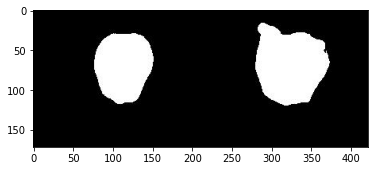

In [ ]:
file_name = "/content/drive/My Drive/DL_Dataset/saved_images/pred_0.jpg"
file = cv2.imread(file_name)
plt.imshow(file)

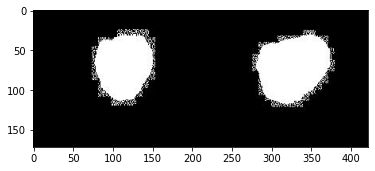

In [ ]:

file_name = "/content/drive/My Drive/DL_Dataset/saved_images/org_0.jpg"
file = cv2.imread(file_name)
plt.imshow(file)